## Descripción del proyecto

Trabajo en una empresa emergente que vende productos alimenticios. Debo investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudiaré el embudo de ventas. Descubriré cómo los usuarios y las usuarias llegan a la etapa de compra. 

Luego, observaré los resultados de un test A/A/B Decifraré y haré seguimiento a los eventos que se produzcan y por último descubriré qué conjunto de fuentes produce mejores resultados.

In [110]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
import scipy.stats as stats
import plotly.express as px
from plotly import graph_objects as go
from scipy.stats import levene, mannwhitneyu, shapiro

### Paso 1

In [111]:
#Importación del dataset para revisión de datos
logs_exp = pd.read_csv('/datasets/logs_exp_us.csv')

In [112]:
print(logs_exp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 1 columns):
 #   Column                                       Non-Null Count   Dtype 
---  ------                                       --------------   ----- 
 0   EventName	DeviceIDHash	EventTimestamp	ExpId  244126 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB
None


### Paso 2: Preparamos los datos para el análisis

In [113]:
#Cambio de nombre de las columnas
print(logs_exp.columns)

Index(['EventName\tDeviceIDHash\tEventTimestamp\tExpId'], dtype='object')


In [114]:
#Separamos las columnas para que sean independientes
logs_exp = logs_exp['EventName\tDeviceIDHash\tEventTimestamp\tExpId'].str.split('\t', expand=True)

#Asignamos nuevos nombres a las columnas
logs_exp.columns = ['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId']
print(logs_exp.columns)

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')


Comprobamos que tipo de datos tenemos y si tenemos valores ausentes. 

In [115]:
print(logs_exp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  object
 2   EventTimestamp  244126 non-null  object
 3   ExpId           244126 non-null  object
dtypes: object(4)
memory usage: 7.5+ MB
None


In [116]:
#Cambiamos el tipo de datos de cada columna de acuerdo a sus características
logs_exp['EventName'] = logs_exp['EventName'].astype(str)
logs_exp['DeviceIDHash'] = logs_exp['DeviceIDHash'].astype(str)
#Cambiamos 'EventTimestamp' a tipo datetime
logs_exp['EventTimestamp'] = pd.to_datetime(logs_exp['EventTimestamp'], unit='s')
logs_exp['ExpId'] = logs_exp['ExpId'].astype(int)

In [117]:
#Verificación de datos usentes
print(logs_exp.isna().sum())

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


No tenemos datos ni valores ausentes

In [118]:
#Verificación de datos duplicados:
print(logs_exp.duplicated().sum())

413


In [119]:
#Eliminamos duplicados
logs_exp.drop_duplicates(inplace=True)
print(logs_exp.duplicated().sum())

0


Tampoco tenemos valores duplicados

In [120]:
#Creamos una columna 'DateTime' que contenga la fecha y hora
logs_exp['DateTime'] = logs_exp['EventTimestamp']

#Creamos otra columna 'Date' que contenga solo la fecha
logs_exp['Date'] = logs_exp['EventTimestamp'].dt.date
logs_exp['Date'] = pd.to_datetime(logs_exp['Date']).dt.date

#Eliminamos la columa 'EventTimestamp'
logs_exp = logs_exp.drop(columns=['EventTimestamp'])

In [121]:
print(logs_exp.head())

                 EventName         DeviceIDHash  ExpId            DateTime  \
0         MainScreenAppear  4575588528974610257    246 2019-07-25 04:43:36   
1         MainScreenAppear  7416695313311560658    246 2019-07-25 11:11:42   
2  PaymentScreenSuccessful  3518123091307005509    248 2019-07-25 11:28:47   
3         CartScreenAppear  3518123091307005509    248 2019-07-25 11:28:47   
4  PaymentScreenSuccessful  6217807653094995999    248 2019-07-25 11:48:42   

         Date  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  
3  2019-07-25  
4  2019-07-25  


### Paso 3: Estudiar y comprobar los datos

In [122]:
#Calcularemos cuántos eventos hay en los registros
total_events = logs_exp.shape[0]
print(total_events)

243713


In [123]:
#Nombre de los eventos únicos
print(logs_exp['EventName'].unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


In [124]:
#Calcularemos cuántos usuarios y usuarias hay en los registros
total_users = logs_exp['DeviceIDHash'].nunique()
print(total_users)

7551


In [125]:
#Calcularemos cuál es el promedio de eventos por usuario
average_events_per_user = total_events / total_users
print(average_events_per_user)

32.27559263673685


Averiguaremos qué periodo de tiempo cubren los datos

In [126]:
# Calculamos las fechas mínimas y máximas que cubren los datos
min_date = logs_exp['DateTime'].min()
max_date = logs_exp['DateTime'].max()

print(f"Fecha mínima: {min_date}")
print(f"Fecha máxima: {max_date}")

Fecha mínima: 2019-07-25 04:43:36
Fecha máxima: 2019-08-07 21:15:17


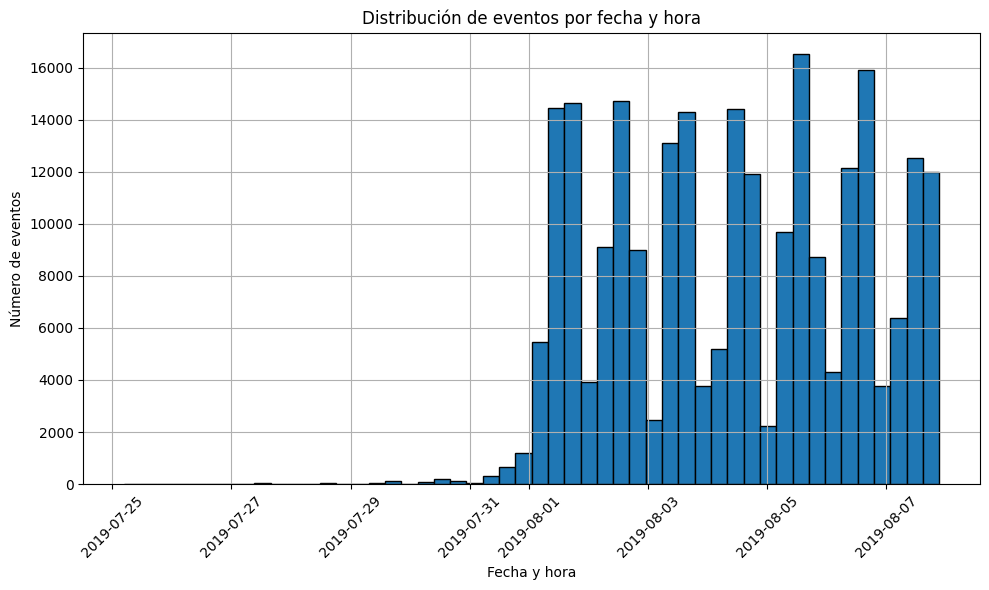

In [127]:
#Graficamos un histograma de distribución de eventos por fecha y hora
plt.figure(figsize=(10, 6))
logs_exp['DateTime'].hist(bins=50, edgecolor='black')
plt.title('Distribución de eventos por fecha y hora')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Lo que nos muestra el gráfico es que:
De acuerdo a la fecha mínima: 2019-07-25: Prácticamente no se tienen eventos.
De acuerdo a la fecha máxima: 2019-08-07: Tenemos 1200 eventos
Se tiene un periodo de 13 dias de eventos entre la fecha mínima y máxima.
Donde el pico de eventos se tuvo el '2019-08-25', con mas de 16000 eventos.

La cantidad de eventos considerables comienzan a partir de '2019-08-01'

In [128]:
#Calculamos la cantidad de eventos y usuarios exluídos entre el '2019-07-25' y '2019-07-31'.

#Definimos las fechas como objetos datetime.date para no tener problemas con el tipo de datos
start_date = pd.to_datetime('2019-07-25').date()
end_date = pd.to_datetime('2019-07-31').date()

#Filtramos las fechas exlcuidas
date_in_range = logs_exp[(logs_exp['Date'] >= start_date) & (logs_exp['Date'] <= end_date)]

#Calculamos la cantidad eventos exluídos
excluded_event_count = date_in_range.shape[0]
print(f'Cantidad de eventos excluídos entre 2019-07-25 y 2019-07-31: {excluded_event_count}')

#Calculamos la cantidad de usuarios exluídos 
excluded_users_count = date_in_range['DeviceIDHash'].nunique()
print(f'Cantidad de usuarios excluídos entre 2019-07-25 y 2019-07-31: {excluded_users_count}')

Cantidad de eventos excluídos entre 2019-07-25 y 2019-07-31: 2826
Cantidad de usuarios excluídos entre 2019-07-25 y 2019-07-31: 1451


Nos aseguraremos de tener usuarios en los tres grupos experimentales

In [129]:
#Nombre de los 3 grupos experimentales
print(logs_exp['ExpId'].unique())

[246 248 247]


In [130]:
#Obtenemos la cantidad de usuarios únicos en cada grupo experimental
users_per_group = logs_exp.groupby('ExpId')['DeviceIDHash'].nunique()
print("Cantidad de usuarios únicos por grupo experimental:")
print(users_per_group)

Cantidad de usuarios únicos por grupo experimental:
ExpId
246    2489
247    2520
248    2542
Name: DeviceIDHash, dtype: int64


In [131]:
#Revisaremos si los usuarios pertenecen a un solo grupo 'ExpdId' y no se repitan en los grupos
group_counts = logs_exp.groupby('DeviceIDHash')['ExpId'].nunique()
print(group_counts)

DeviceIDHash
1000608915523616548    1
100724994572555335     1
1008242126838007188    1
1009503747199967885    1
1009745980451513098    1
                      ..
992321565231279868     1
993193057518949787     1
995065401066914588     1
997141886226099626     1
997959739029313547     1
Name: ExpId, Length: 7551, dtype: int64


In [132]:
#Filtramos los usuarios que están en mas de 1 grupo
duplicate_users = group_counts[group_counts > 1]

if not duplicate_users.empty:
    print(f"Hay {duplicate_users.shape[0]} usuarios que están en más de un grupo:")
    print(duplicate_users)
else:
    print("No hay usuarios que estén en más de un grupo.")

No hay usuarios que estén en más de un grupo.


### Paso 4: Estudio de embudo de eventos

1. Empezaremos observando qué eventos hay en los registros y su frecuencia de suceso, los ordenaremos por su frecuencia.

In [133]:
#Contaremos la frecuencia en cada evento, los datos se encuenrtan en la columna 'EventName'
event_frequencies = logs_exp['EventName'].value_counts()
print(event_frequencies)

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: EventName, dtype: int64


In [134]:
#Ordenamos los resultados por frecuencia de suceso
sorted_event_frequencies = event_frequencies.sort_values(ascending=False)
print(sorted_event_frequencies)

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: EventName, dtype: int64


2. Buscaremos la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordenaremos los eventos por el número de usuarios y usuarias. 

In [135]:
#Contamos la cantidad de usuarios únicos que realizaron cada una de estas acciones (eventos)
user_per_event = logs_exp.groupby('EventName')['DeviceIDHash'].nunique()

#Los ordenamos por el número de usuarios de mayor a menor
sorted_user_per_event = user_per_event.sort_values(ascending=False)
print(sorted_user_per_event)

EventName
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: DeviceIDHash, dtype: int64


In [136]:
# Calcularemos la proporción de usuarios y usuarias que realizaron la acción(evento) al menos una vez

#Primero calculamos el número total de usuarios únicos
total_users = logs_exp['DeviceIDHash'].nunique()
print(total_users)

7551


In [137]:
#Anterior mente averiguamos la cantidad de usuarios únicos que realizaron cada acción = user_per_event

#Calculamos la proporción de usuarios que realizaron la acción, las ordenaremos de mayor a menor 
proportion_users_per_event = user_per_event / total_users * 100
print(proportion_users_per_event.sort_values(ascending=False))

EventName
MainScreenAppear           98.516753
OffersScreenAppear         61.091246
CartScreenAppear           49.649053
PaymentScreenSuccessful    46.973911
Tutorial                   11.217057
Name: DeviceIDHash, dtype: float64


In [ ]:
fig = go.Figure(go.Funnel(
    y = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'],
    x = [7439, 4613, 3749, 3547, 847],
    text=proportion_users_per_event.sort_values(ascending=False).apply(lambda x: f'{x:.2f}%')
))
fig.show()

4. El gráfico nos muestra la cantidad de usuarios que pertenecen a cada uno de los eventos y como va disminuyendo la cantidad de usuarios hasta llegar a la última etapa. Se pierden mas usuarios en las etapas de MainScreenAppear a OfferScreen con 2826 usuarios y en la transición de PaymentScreen a Tutorial 2700 usuarios. Al final solo llega el 47.97% a realizar el pago y un 11.22% a llevar el tutorial.

3. Averiguaremos en que orden ocurrieron las acciones y si es que todas son parte de una sola secuencia

In [139]:
#Nos aseguramos que los datos estén ordenados por usuario y tiempo
logs_exp_sorted = logs_exp.sort_values(by=['DeviceIDHash', 'DateTime'])

#Contatenamos los nombre de los eventos en el orden que ocurrieron para cada tipo de usuario
event_sequences = logs_exp_sorted.groupby('DeviceIDHash')['EventName'].apply(lambda x: ' -> '.join(x))

#Contamos las frecuencias de ocurrencia de acciones mas comunes
sequences_counts = event_sequences.value_counts()
print(sequences_counts.head(10))

MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear                                                                                                                            158
MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear                                                                                                        146
MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear                                                                                                                                                146
MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear -> MainScreenAppear                                                                145
MainScreenAppear -> MainScreenAppear -> MainScreenAppear                                                

Este es el orden de flujo que aparecerá en la mayoría de los casos, no se sabe con certeza la posibilidad de que los usuarios realicen en orden diferente los eventos, existen posibilidades de que se salteen eventos si es que la aplicación mantiene la sesión abierta, o tal vez con un link puedan llegar directamente a la oferta, incluso poder saltar directamente hasta CartScreen la parte del carrito de compras, muchas veces tiene su propia URL. Puede existir la posibilidad de estar en el carrito de compras y  regresar a MainScreen a comprar algo más que pueda haber olvidado el usuario.

### Paso 5: Estudiar los resultados del experimento

In [140]:
#Averiguaremos cuantos usuarios hay por evento
users_per_group = logs_exp_sorted.groupby('ExpId')['DeviceIDHash'].nunique()
print(users_per_group)

ExpId
246    2489
247    2520
248    2542
Name: DeviceIDHash, dtype: int64


2.Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observaremos si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [141]:
#Filtramos los datos para los grupos 246 y 247
group_246 = logs_exp[logs_exp['ExpId'] == 246]
group_247 = logs_exp[logs_exp['ExpId'] == 247]

#Obtenemos los eventos únicos
events = logs_exp['EventName'].unique()
print(events)

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


In [142]:
#Creamos un DataFrame para guardar los resultados de las pruebas
results = pd.DataFrame(columns=['EventName', 'Shapiro_246_pvalue', 'Shapiro_247_pvalue', 'Levene_pvalue', 'MannWhitney_pvalue'])

#Comparamos cada evento entre los dos grupos
for event in events:
    event_246 = group_246[group_246['EventName'] == event]['DeviceIDHash'].value_counts()
    event_247 = group_247[group_247['EventName'] == event]['DeviceIDHash'].value_counts()
    
    #Realizamos la prueba de SHAPIRO-WILK para verificar la normalidad de los datos
    shapiro_246_stat, shapiro_246_p = shapiro(event_246)
    shapiro_247stat, shapiro_247_p = shapiro(event_247)
    
    #Realizamos la prueba de Levene para verificar la igualdad de varianza
    levene_stat, levene_p = levene(event_246, event_247, center='mean')
    
    #Realizamos la prueba de # Realizar la prueba de Mann-Whitney para comparar las medianas si los datos no son normales
    mann_stat, mann_p = mannwhitneyu(event_246, event_247, alternative='two-sided')
    
    # Almacenamos los resultados
    results = results.append({
        'EventName': event,
        'Shapiro_246_pvalue': shapiro_246_p,
        'Shapiro_247_pvalue': shapiro_247_p,
        'Levene_pvalue': levene_p,
        'MannWhitney_pvalue': mann_p
    }, ignore_index=True)

print(results)

                 EventName  Shapiro_246_pvalue  Shapiro_247_pvalue  \
0         MainScreenAppear        0.000000e+00        0.000000e+00   
1  PaymentScreenSuccessful        0.000000e+00        0.000000e+00   
2         CartScreenAppear        0.000000e+00        0.000000e+00   
3       OffersScreenAppear        0.000000e+00        0.000000e+00   
4                 Tutorial        4.043993e-32        2.540946e-33   

   Levene_pvalue  MannWhitney_pvalue  
0       0.286818            0.612596  
1       0.206512            0.390494  
2       0.103485            0.518247  
3       0.160090            0.763865  
4       0.096084            0.253391  


In [143]:
# Verificamos si hay diferencias estadísticamente significativas
significant_levene = results[results['Levene_pvalue'] < 0.05]
significant_mannwhitney = results[results['MannWhitney_pvalue'] < 0.05]

print("\nEventos con diferencias significativas en la varianza (Levene test):")
print(significant_levene)

print("\nEventos con diferencias significativas en la mediana (Mann-Whitney test):")
print(significant_mannwhitney)


Eventos con diferencias significativas en la varianza (Levene test):
Empty DataFrame
Columns: [EventName, Shapiro_246_pvalue, Shapiro_247_pvalue, Levene_pvalue, MannWhitney_pvalue]
Index: []

Eventos con diferencias significativas en la mediana (Mann-Whitney test):
Empty DataFrame
Columns: [EventName, Shapiro_246_pvalue, Shapiro_247_pvalue, Levene_pvalue, MannWhitney_pvalue]
Index: []


De acuerdo a los resultados Shapiro_246_pvalue y Shapiro_247_pvalue: Los valores p para ambas columnas son extremadamente bajos (0.000000e+00), lo que significa que se rechaza la hipótesis nula de que los datos siguen una distribución normal. En otras palabras, los datos en ambos grupos (246 y 247) no son normales para todos los eventos.

De acuerdo a los resultados Levene verifica si las varianzas de los dos grupos son iguales. Los valores p son todos mayores que 0.05, lo que indica que no hay diferencias significativas en la varianza entre los grupos 246 y 247 para ninguno de los eventos. Esto significa que las varianzas de los eventos en ambos grupos son similares.

La prueba de Mann-Whitney compara las medianas de los dos grupos. Los valores p son todos mayores que 0.05, lo que significa que no hay diferencias estadísticamente significativas en las medianas de los eventos entre los grupos 246 y 247. Esto significa que la distribución de los eventos en ambos grupos es similar en los valores de las medianas.

3.1 Averiguaremos cual es el evento más popular. En cada uno de los grupos de control, buscaremos la cantidad de usuarios y usuarias que realizaron esta acción y encontraremos su proporción.

In [144]:
#Encontramos el evento más popular
most_popular_event = logs_exp['EventName'].value_counts(ascending=False)
print(most_popular_event)

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: EventName, dtype: int64


In [145]:
#Analizamos la cantidad de usuarios que realizaron el evento más popular
users_246 = group_246[group_246['EventName'] == 'MainScreenAppear']['DeviceIDHash'].nunique()
users_247 = group_247[group_247['EventName'] == 'MainScreenAppear']['DeviceIDHash'].nunique()
print("Cantidad de usuarios que realizaron el evento más popular en grupo 246:")
print(users_246)
print("\nCantidad de usuarios que realizaron el evento más popular en grupo 247:")
print(users_247)

Cantidad de usuarios que realizaron el evento más popular en grupo 246:
2456

Cantidad de usuarios que realizaron el evento más popular en grupo 247:
2482


In [146]:
#Calcularemos la proporción de usuarios que realizaron el evento más popular

#total de usuarions en cada grupo
total_users_246 = group_246['DeviceIDHash'].nunique()
total_users_247 = group_247['DeviceIDHash'].nunique()
print(total_users_246)
print(total_users_247)

2489
2520


In [147]:
#Proporción de usuarios que realizaron el evento más popular
proportion_246 = (users_246 / total_users_246)*100
proportion_247 = (users_247 / total_users_247)*100
print("Proporción de usuarios que realizaron el evento más popular en grupo 246:")
print(proportion_246)
print("Proporción de usuarios que realizaron el evento más popular en grupo 247:")
print(proportion_247)

Proporción de usuarios que realizaron el evento más popular en grupo 246:
98.67416633186018
Proporción de usuarios que realizaron el evento más popular en grupo 247:
98.4920634920635


3.2 Comprobaremos si la diferencia entre los grupos es estadísticamente significativa. Repetiremos el procedimiento para todos los demás eventos.

Ya comprobamos que los datos no siguen una ditribución normal, es por eso que utilizaremos la prueba de Mann-Whitney U

In [148]:
#Utilizaremos una función para ahorrar tiempo en las comparaciones entre los grupos:
def mann_whitney_test(event_name, group_1, group_2):
    # Contar la cantidad de usuarios únicos que realizaron el evento en cada grupo
    group_1_event_count = group_1[group_1['EventName'] == event_name]['DeviceIDHash'].nunique()
    group_2_event_count = group_2[group_2['EventName'] == event_name]['DeviceIDHash'].nunique()
    
    # Creamos una lista con las cantidades de usuarios por grupo
    data = [group_1_event_count, group_2_event_count]
    
    # Realizamos la prueba de Mann-Whitney 
    stat, p_value = stats.mannwhitneyu(data, data, alternative='two-sided')
    
    return p_value

In [149]:
# Seleccionamos los eventos únicos
events = logs_exp['EventName'].unique()

# Filtramos los datos para los grupos de control 246 y 247 y el grupo experimental 248
group_246 = logs_exp[logs_exp['ExpId'] == 246]
group_247 = logs_exp[logs_exp['ExpId'] == 247]
group_248 = logs_exp[logs_exp['ExpId'] == 248]

# Realizamos las pruebas A/A para cada evento
aa_results = {}
for event in events:
    p_value = mann_whitney_test(event, group_246, group_247)
    aa_results[event] = p_value

# Realizamos las pruebas A/B para cada evento
ab_results = {}
for event in events:
    p_value = mann_whitney_test(event, group_246, group_248)
    ab_results[event] = p_value

In [150]:
# Mostramos los resultados de la función y las pruebas
print("Resultados de la prueba A/A (Grupo 246 vs Grupo 247):")
for event, p_value in aa_results.items():
    print(f"Evento: {event}, p-value: {p_value:.6f}")

print("\nResultados de la prueba A/B (Grupo 246 vs Grupo 248):")
for event, p_value in ab_results.items():
    print(f"Evento: {event}, p-value: {p_value:.6f}")

# Confirmamos si tenemos una correcta división de los grupos
significance_threshold = 0.05
aa_correct = all(p > significance_threshold for p in aa_results.values())
print(f"\n¿La separación de los grupos A/A fue correcta? {'Sí' if aa_correct else 'No'}")

Resultados de la prueba A/A (Grupo 246 vs Grupo 247):
Evento: MainScreenAppear, p-value: 1.000000
Evento: PaymentScreenSuccessful, p-value: 1.000000
Evento: CartScreenAppear, p-value: 1.000000
Evento: OffersScreenAppear, p-value: 1.000000
Evento: Tutorial, p-value: 1.000000

Resultados de la prueba A/B (Grupo 246 vs Grupo 248):
Evento: MainScreenAppear, p-value: 1.000000
Evento: PaymentScreenSuccessful, p-value: 1.000000
Evento: CartScreenAppear, p-value: 1.000000
Evento: OffersScreenAppear, p-value: 1.000000
Evento: Tutorial, p-value: 1.000000

¿La separación de los grupos A/A fue correcta? Sí


En la prueba A/A: Los resultados nos indican que un p-valor de 1.000 significa que no hay evidencia suficiente para rechazar la hipótesis nula de que no hay diferencias en la cantidad de usuarios que realizaron los eventos entre los dos grupos de control. Esto significa que la división de los usuarios en los grupos de control se realizó correctamente.

En la prueba A/B. El valor de p-valor de 1.000 también nos indica que no hay evidencia suficiente para rechazar la hipótesis nula de que no hay diferencias en la cantidad de usuarios que realizaron los eventos entre el grupo de control 246 y el grupo experimental 248. Este resultado significa que según los datos de eventos, el grupo experimental 248 no muestra diferencias significativas en los eventos en comparación con el grupo de control 246.

4. Ahora haremos lo mismo para el grupo con fuentes alteradas. Compararemos los resultados con los de cada uno de los grupos de control para cada evento de forma aislada y Compararemos los resultados con los resultados combinados de los grupos de control. 

In [151]:
#Función para realizar las pruebas A/A y A/B con fuentes alteradas
def compare_events(group_a, group_b, event_name):
    users_a = group_a[group_a['EventName'] == event_name]['DeviceIDHash'].nunique()
    users_b = group_b[group_b['EventName'] == event_name]['DeviceIDHash'].nunique()
    
    # Realizamos la prueba de Mann-Whitney
    mannwhitney_pvalue = stats.mannwhitneyu(
        group_a[group_a['EventName'] == event_name]['DeviceIDHash'].rank(),
        group_b[group_b['EventName'] == event_name]['DeviceIDHash'].rank(),
        alternative='two-sided'
    ).pvalue
    
    return users_a, users_b, mannwhitney_pvalue

In [152]:
#Ahora iteramos sobre los eventos y realizamos las pruebas:
event_results = []
for event in logs_exp['EventName'].unique():
    users_246, users_247, p_value_aa = compare_events(group_246, group_247, event)
    users_246, users_248, p_value_ab = compare_events(group_246, group_248, event)

    event_results.append({
        'EventName': event,
        'Users_246': users_246,
        'Users_247': users_247,
        'Users_248': users_248,
        'p_value_AA': p_value_aa,
        'p_value_AB': p_value_ab
    })

results_df = pd.DataFrame(event_results)
print(results_df)

                 EventName  Users_246  Users_247  Users_248     p_value_AA  \
0         MainScreenAppear       2456       2482       2501   3.484233e-18   
1  PaymentScreenSuccessful       1202       1160       1185   1.382241e-92   
2         CartScreenAppear       1270       1240       1239  3.428103e-106   
3       OffersScreenAppear       1545       1530       1538   1.707279e-05   
4                 Tutorial        279        286        282   8.165029e-02   

     p_value_AB  
0  2.382053e-67  
1  4.330185e-03  
2  2.237995e-07  
3  2.545241e-53  
4  1.945941e-02  


Comparación de forma aislada - Comparación A/A (Grupos 246 vs 247): Valores extremadamente bajos de p-value (cerca de 0): Indican que existen diferencias estadísticamente significativas entre los grupos de control 246 y 247 para esos eventos, especialmente en los eventos "PaymentScreenSuccessful" y "CartScreenAppear", quiere decir que estos dos grupos no se dividieron de manera equitativa para esos eventos.

Comparación combinada - Comparación A/B (Grupos 246 y 247 vs 248): Valores bajos de p-value (cerca o inferiores a 0.05): Esto indica que existen diferencias estadísticamente significativas entre el grupo combinado y el grupo experimental 248. Para eventos como "MainScreenAppear", "CartScreenAppear", y "OffersScreenAppear", el p-value es extremadamente bajo, lo que quiere decir que la intervención realizada en el grupo experimental 248 tiene una comparación grande con el grupo de control 248.

5.Ya que hemos realizado muchos tests tenemos la probabilidad de que nuestros resultados sean incorrectos, tenemos que darle un nuevo valor, ahora trabajaremos un al alfa de 0.025. Realizaremos el mismo procedimiento y veremos los resultados.

In [157]:
# Función para realizar las pruebas estadísticas
def perform_tests(group_control, group_experiment, event_name):
    # Filtramos los datos para el evento específico
    control_data = group_control[group_control['EventName'] == event_name]['DeviceIDHash'].dropna().astype('int64')
    experiment_data = group_experiment[group_experiment['EventName'] == event_name]['DeviceIDHash'].dropna().astype('int64')
    
    # Prueba de Levene para la igualdad de varianzas
    levene_pvalue = levene(control_data, experiment_data)[1]
    
    # Prueba de Mann-Whitney U para comparar las distribuciones
    mannwhitney_pvalue = mannwhitneyu(control_data, experiment_data, alternative='two-sided')[1]
    
    return levene_pvalue, mannwhitney_pvalue

In [158]:
# Seleccionamos los eventos
event_names = logs_exp['EventName'].unique()

# Grupos
group_246 = logs_exp[logs_exp['ExpId'] == 246]
group_247 = logs_exp[logs_exp['ExpId'] == 247]
group_248 = logs_exp[logs_exp['ExpId'] == 248]
group_control_combined = pd.concat([group_246, group_247])

In [159]:
# Creamos un DataFrame para almacenar los resultados
results = []

# Realizamos las pruebas para cada evento
for event in event_names:
    # Prueba A/B: 246 vs 248
    levene_pvalue_246_248, mannwhitney_pvalue_246_248 = perform_tests(group_246, group_248, event)
    
    # Prueba A/B: 247 vs 248
    levene_pvalue_247_248, mannwhitney_pvalue_247_248 = perform_tests(group_247, group_248, event)
    
    # Prueba combinada A/B: 246 + 247 vs 248
    levene_pvalue_combined_248, mannwhitney_pvalue_combined_248 = perform_tests(group_control_combined, group_248, event)
    
    # Agregamos los resultados al DataFrame
    results.append({
        'EventName': event,
        'Levene_pvalue_246_248': levene_pvalue_246_248,
        'MannWhitney_pvalue_246_248': mannwhitney_pvalue_246_248,
        'Levene_pvalue_247_248': levene_pvalue_247_248,
        'MannWhitney_pvalue_247_248': mannwhitney_pvalue_247_248,
        'Levene_pvalue_combined_248': levene_pvalue_combined_248,
        'MannWhitney_pvalue_combined_248': mannwhitney_pvalue_combined_248
    })

# Convertimos los resultados a un DataFrame para facilitarnos su visualización
results_df = pd.DataFrame(results)

In [162]:
# Filtramos los resultados con un alfa ajustado de 0.025
significant_results = results_df[
    (results_df['MannWhitney_pvalue_246_248'] < 0.025) |
    (results_df['MannWhitney_pvalue_247_248'] < 0.025) |
    (results_df['MannWhitney_pvalue_combined_248'] < 0.025)
]

print("Resultados significativos después de ajustar el valor alfa:")
print(significant_results)

Resultados significativos después de ajustar el valor alfa:
                 EventName  Levene_pvalue_246_248  MannWhitney_pvalue_246_248  \
0         MainScreenAppear           8.532718e-12                1.663407e-01   
1  PaymentScreenSuccessful          4.542926e-122                1.833392e-06   
2         CartScreenAppear          7.947006e-134                2.471692e-08   
3       OffersScreenAppear           4.637580e-41                7.742008e-22   

   Levene_pvalue_247_248  MannWhitney_pvalue_247_248  \
0               0.393989                1.061412e-08   
1               0.293956                6.883948e-04   
2               0.098434                2.816445e-02   
3               0.002152                7.917001e-01   

   Levene_pvalue_combined_248  MannWhitney_pvalue_combined_248  
0                9.146633e-06                     3.251466e-05  
1                6.806816e-44                     1.554178e-06  
2                5.038985e-46                     3.361223

Conclusiones de los resultados:El evento "OffersScreenAppear" muestra diferencias significativas en la varianza y en la distribución, sobre todo entre el grupo 246 y el combinado con el grupo 248. Esto indica que las ofertas podrían haberse presentado de manera diferente en el grupo experimental.

Dado que los resultados nos indican que hay diferencias significativas entre los grupos de control y el grupo experimental en varios eventos. Esto podría sugerir que el grupo experimental se comportó de manera diferente debido a algunas alteraciones introducidas. Los grupos de control 246 y 247 parecen no mostrar diferencias significativas, lo que indica que la separación de los usuarios en estos grupos fue adecuada. Sin embargo, el grupo experimental (248) muestra comportamientos distintos, lo que puede estar relacionado con el experimento aplicado.